In [3]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())

0.4.0
True


In [0]:
# Importing the required header files
import os
import torch
import torchvision
import torch.nn as nn
from torchvision import transforms
from torchvision.utils import save_image

In [0]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [0]:
# Hyper-parameters
latent_size = 64
hidden_size = 256
image_size = 784
num_epochs = 50
batch_size = 100
sample_dir = 'samples'
# Can be optimized later

In [0]:
# Create a directory if not exists
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

In [0]:
# Image processing
transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(mean=(0.5, 0.5, 0.5),   # 3 for RGB channels
                                     std=(0.5, 0.5, 0.5))])

In [9]:
# MNIST dataset
mnist = torchvision.datasets.MNIST(root='../../data/',
                                   train=True,
                                   transform=transform,
                                   download=True)

Processing...
Done!


In [0]:
# Data loader
data_loader = torch.utils.data.DataLoader(dataset=mnist,
                                          batch_size=batch_size, 
                                          shuffle=True)


In [0]:
# Discriminator
D = nn.Sequential(
    nn.Linear(image_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, 1),
    nn.Sigmoid())


In [0]:
# Generator 
G = nn.Sequential(
    nn.Linear(latent_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, image_size),
    nn.Tanh())

In [0]:
# Device setting
D = D.to(device)
G = G.to(device)



In [14]:
device

device(type='cuda')

In [0]:
# Binary cross entropy loss and optimizer
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002)
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002)


In [0]:
# For denorm
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)


In [0]:
# For resetting or zeroing gradients
def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()


In [0]:
# To visualize images
import matplotlib.pyplot as plt


In [22]:
# Start training
total_step = len(data_loader)
for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        images = images.reshape(batch_size, -1).to(device)
        
        # Create the labels which are later used as input for the BCE loss
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # ================================================================== #
        #                      Train the discriminator                       #
        # ================================================================== #

        # Compute BCE_Loss using real images where BCE_Loss(x, y): - y * log(D(x)) - (1-y) * log(1 - D(x))
        # Second term of the loss is always zero since real_labels == 1
        outputs = D(images)
        d_loss_real = criterion(outputs, real_labels)
        real_score = outputs
        
        # Compute BCELoss using fake images
        # First term of the loss is always zero since fake_labels == 0
        z = torch.randn(batch_size, latent_size).to(device)
        fake_images = G(z)
        outputs = D(fake_images)
        d_loss_fake = criterion(outputs, fake_labels)
        fake_score = outputs
        
        # Backprop and optimize
        d_loss = d_loss_real + d_loss_fake
        reset_grad()
        d_loss.backward()
        d_optimizer.step()
        
        # ================================================================== #
        #                        Train the generator                         #
        # ================================================================== #

        # Compute loss with fake images
        z = torch.randn(batch_size, latent_size).to(device)
        fake_images = G(z)
        outputs = D(fake_images)
        
        # We train G to maximize log(D(G(z)) instead of minimizing log(1-D(G(z)))
        # For the reason, see the last paragraph of section 3. https://arxiv.org/pdf/1406.2661.pdf
        g_loss = criterion(outputs, real_labels)
        
        # Backprop and optimize
        reset_grad()
        g_loss.backward()
        g_optimizer.step()
        
        if (i+1) % 200 == 0:
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}' 
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(), 
                          real_score.mean().item(), fake_score.mean().item()))
    
    # Save real images
    if (epoch+1) == 1:
        images = images.reshape(images.size(0), 1, 28, 28)
        save_image(denorm(images), os.path.join(sample_dir, 'real_images.png'))
    
    # Save sampled images
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    save_image(denorm(fake_images), os.path.join(sample_dir, 'fake_images-{}.png'.format(epoch+1)))

    
    
# Save the model checkpoints 
torch.save(G.state_dict(), 'G.ckpt')
torch.save(D.state_dict(), 'D.ckpt')


Epoch [0/50], Step [200/600], d_loss: 0.5139, g_loss: 5.5538, D(x): 0.85, D(G(z)): 0.02
Epoch [0/50], Step [400/600], d_loss: 0.1460, g_loss: 4.2064, D(x): 1.00, D(G(z)): 0.11
Epoch [0/50], Step [600/600], d_loss: 0.4160, g_loss: 4.3301, D(x): 0.90, D(G(z)): 0.07
Epoch [1/50], Step [200/600], d_loss: 0.4452, g_loss: 7.1634, D(x): 0.85, D(G(z)): 0.01
Epoch [1/50], Step [400/600], d_loss: 0.2107, g_loss: 4.6808, D(x): 0.95, D(G(z)): 0.06
Epoch [1/50], Step [600/600], d_loss: 0.1540, g_loss: 3.6428, D(x): 0.94, D(G(z)): 0.04
Epoch [2/50], Step [200/600], d_loss: 0.7177, g_loss: 2.8026, D(x): 0.92, D(G(z)): 0.25
Epoch [2/50], Step [400/600], d_loss: 0.2266, g_loss: 4.4726, D(x): 0.93, D(G(z)): 0.02
Epoch [2/50], Step [600/600], d_loss: 0.2720, g_loss: 4.3109, D(x): 0.92, D(G(z)): 0.06
Epoch [3/50], Step [200/600], d_loss: 0.2463, g_loss: 5.8640, D(x): 0.91, D(G(z)): 0.03
Epoch [3/50], Step [400/600], d_loss: 0.3289, g_loss: 4.0680, D(x): 0.92, D(G(z)): 0.10
Epoch [3/50], Step [600/600], d_

Epoch [15/50], Step [600/600], d_loss: 0.4707, g_loss: 4.1007, D(x): 0.84, D(G(z)): 0.08
Epoch [16/50], Step [200/600], d_loss: 0.3988, g_loss: 4.2122, D(x): 0.86, D(G(z)): 0.07
Epoch [16/50], Step [400/600], d_loss: 0.2420, g_loss: 5.1453, D(x): 0.90, D(G(z)): 0.03
Epoch [16/50], Step [600/600], d_loss: 0.2973, g_loss: 3.6246, D(x): 0.90, D(G(z)): 0.08
Epoch [17/50], Step [200/600], d_loss: 0.3125, g_loss: 4.5947, D(x): 0.92, D(G(z)): 0.11
Epoch [17/50], Step [400/600], d_loss: 0.3090, g_loss: 5.0473, D(x): 0.89, D(G(z)): 0.07
Epoch [17/50], Step [600/600], d_loss: 0.2135, g_loss: 3.3290, D(x): 0.92, D(G(z)): 0.08
Epoch [18/50], Step [200/600], d_loss: 0.3435, g_loss: 5.7228, D(x): 0.92, D(G(z)): 0.12
Epoch [18/50], Step [400/600], d_loss: 0.6159, g_loss: 3.0146, D(x): 0.96, D(G(z)): 0.32
Epoch [18/50], Step [600/600], d_loss: 0.2675, g_loss: 3.0550, D(x): 0.93, D(G(z)): 0.11
Epoch [19/50], Step [200/600], d_loss: 0.2913, g_loss: 4.4673, D(x): 0.88, D(G(z)): 0.04
Epoch [19/50], Step [

Epoch [31/50], Step [200/600], d_loss: 0.6397, g_loss: 3.0305, D(x): 0.76, D(G(z)): 0.09
Epoch [31/50], Step [400/600], d_loss: 0.4115, g_loss: 2.6732, D(x): 0.93, D(G(z)): 0.20
Epoch [31/50], Step [600/600], d_loss: 0.4660, g_loss: 2.7181, D(x): 0.81, D(G(z)): 0.11
Epoch [32/50], Step [200/600], d_loss: 0.4130, g_loss: 2.8459, D(x): 0.87, D(G(z)): 0.15
Epoch [32/50], Step [400/600], d_loss: 0.5656, g_loss: 3.2715, D(x): 0.84, D(G(z)): 0.21
Epoch [32/50], Step [600/600], d_loss: 0.7015, g_loss: 1.8221, D(x): 0.77, D(G(z)): 0.19
Epoch [33/50], Step [200/600], d_loss: 0.5751, g_loss: 2.0934, D(x): 0.82, D(G(z)): 0.19
Epoch [33/50], Step [400/600], d_loss: 0.5406, g_loss: 3.1736, D(x): 0.80, D(G(z)): 0.14
Epoch [33/50], Step [600/600], d_loss: 0.5007, g_loss: 2.6822, D(x): 0.79, D(G(z)): 0.10
Epoch [34/50], Step [200/600], d_loss: 0.6258, g_loss: 2.9644, D(x): 0.85, D(G(z)): 0.25
Epoch [34/50], Step [400/600], d_loss: 0.5562, g_loss: 3.0895, D(x): 0.82, D(G(z)): 0.14
Epoch [34/50], Step [

Epoch [46/50], Step [400/600], d_loss: 0.6486, g_loss: 1.8341, D(x): 0.81, D(G(z)): 0.25
Epoch [46/50], Step [600/600], d_loss: 0.7829, g_loss: 1.9945, D(x): 0.76, D(G(z)): 0.23
Epoch [47/50], Step [200/600], d_loss: 0.7277, g_loss: 2.2566, D(x): 0.77, D(G(z)): 0.20
Epoch [47/50], Step [400/600], d_loss: 0.5930, g_loss: 2.8342, D(x): 0.78, D(G(z)): 0.18
Epoch [47/50], Step [600/600], d_loss: 0.5997, g_loss: 2.7440, D(x): 0.79, D(G(z)): 0.15
Epoch [48/50], Step [200/600], d_loss: 0.8701, g_loss: 2.3660, D(x): 0.69, D(G(z)): 0.18
Epoch [48/50], Step [400/600], d_loss: 0.5826, g_loss: 2.9120, D(x): 0.80, D(G(z)): 0.17
Epoch [48/50], Step [600/600], d_loss: 0.6536, g_loss: 2.4498, D(x): 0.85, D(G(z)): 0.28
Epoch [49/50], Step [200/600], d_loss: 0.5711, g_loss: 2.6470, D(x): 0.86, D(G(z)): 0.25
Epoch [49/50], Step [400/600], d_loss: 0.7656, g_loss: 2.4494, D(x): 0.78, D(G(z)): 0.23
Epoch [49/50], Step [600/600], d_loss: 0.5356, g_loss: 3.2763, D(x): 0.85, D(G(z)): 0.21


In [23]:
!ls

datalab  D.ckpt  G.ckpt  processed  raw  samples


In [0]:
os.chdir('samples')

In [26]:
!ls

fake_images-10.png  fake_images-22.png	fake_images-34.png  fake_images-46.png
fake_images-11.png  fake_images-23.png	fake_images-35.png  fake_images-47.png
fake_images-12.png  fake_images-24.png	fake_images-36.png  fake_images-48.png
fake_images-13.png  fake_images-25.png	fake_images-37.png  fake_images-49.png
fake_images-14.png  fake_images-26.png	fake_images-38.png  fake_images-4.png
fake_images-15.png  fake_images-27.png	fake_images-39.png  fake_images-50.png
fake_images-16.png  fake_images-28.png	fake_images-3.png   fake_images-5.png
fake_images-17.png  fake_images-29.png	fake_images-40.png  fake_images-6.png
fake_images-18.png  fake_images-2.png	fake_images-41.png  fake_images-7.png
fake_images-19.png  fake_images-30.png	fake_images-42.png  fake_images-8.png
fake_images-1.png   fake_images-31.png	fake_images-43.png  fake_images-9.png
fake_images-20.png  fake_images-32.png	fake_images-44.png  real_images.png
fake_images-21.png  fake_images-33.png	fake_images-45.png


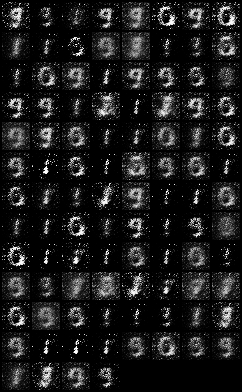

In [28]:
from IPython.display import Image
Image('fake_images-1.png')

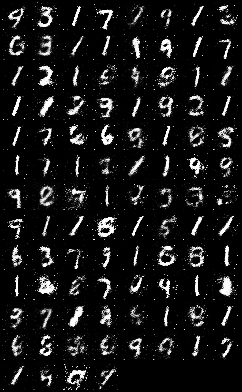

In [29]:
from IPython.display import Image
Image('fake_images-50.png')

In [0]:
# From the above two images we can see the stark difference in the fake images created at the end of epochs 1 and 50 respectiveley

In [0]:
# Better results can be obtained from sophisticated architectures and training for longer epochs and also GANs seem to better at this than VAEs